In [1]:
import copy
import numpy as np
import astropy.units as u
from scipy.io import readsav
import sys
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize,LogStretch
from astropy.wcs.utils import pixel_to_pixel, wcs_to_celestial_frame
import sunpy.map
from sunpy.coordinates import get_earth
import reproject
import ndcube

from overlappy.reproject import reproject_to_overlappogram
from overlappy.util import color_lat_lon_axes, draw_hgs_grid

sys.path.append('../scripts')
from util import (
    make_moxsi_ndcube,
    #overlappogram_wcs,
    #construct_pcij,
    #color_lat_lon_axes,
    #reproject_to_overlappogram,
    #construct_overlappogram
)

In [2]:
norm=ImageNormalize(vmin=0,vmax=1,stretch=LogStretch())
cmap='hinodexrt'
plot_props = {'cmap':cmap, 'norm':norm}

# Testing with `reproject`

I've been doing the overlappogram construction in a pretty haphazard way, by rotating and shifting images before adding them directly into the array.
Why don't we instead just use our established WCS and reproject from the cube into the array?

First, load our test data

In [5]:
savdata = readsav('../data/forDan_MOXSI_DATA_09112020_0440_feldman.sav')
intensities = savdata['moxsi1_img']
wavelength = savdata['cubixss_wave'] * u.angstrom
DETECTOR_SHAPE = (2000, 750)

In [6]:
wavelength

<Quantity [ 1.   ,  1.055,  1.11 , ..., 59.85 , 59.905, 59.96 ] Angstrom>

In [7]:
wavelength.shape

(1073,)

In [8]:
observer=get_earth(time='2020-01-01T00:00:00')

In [9]:
moxsi_cube = make_moxsi_ndcube(
    intensities,
    wavelength,
    observer=observer
)

In [10]:
wavelength = moxsi_cube.axis_world_coords(0)[0]

Can we reproject a slice of the cube into our overlappogram WCS?

In [23]:
pc_matrix = construct_pcij(0*u.deg, 0*u.deg, order=-1)
overlap_wcs = overlappogram_wcs(
    DETECTOR_SHAPE,
    wavelength,
    moxsi_cube.wcs.wcs.cdelt,
    moxsi_cube.wcs.wcs.cunit,
    pc_matrix,
    observer,
)

We'll select a particular wavelength to reproject. We then need to adjust the reference pixel to account for this offset in index.

In [36]:
i_select = 0
#overlap_wcs.wcs.crpix[2] = overlap_wcs.wcs.crpix[2] - i_select
shape_out = (1,) + DETECTOR_SHAPE

In [37]:
overlap_data,_ = reproject.reproject_interp(
    moxsi_cube[i_select:i_select+1,:,:],
    overlap_wcs,
    shape_out=shape_out,
)
overlap_cube = ndcube.NDCube(overlap_data, wcs=overlap_wcs)

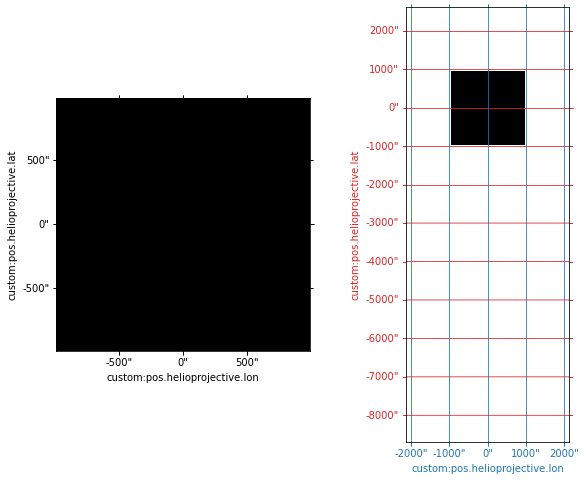

In [38]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(121,projection=moxsi_cube[i_select].wcs)
moxsi_cube[i_select].plot(axes=ax,**plot_props)
ax = fig.add_subplot(122, projection=overlap_cube[0].wcs)
overlap_cube[0].plot(axes=ax,**plot_props)
_ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})

Can you select multiple entries and then reproject?

In [12]:
select_slice = np.s_[325:335,:,:]

In [15]:
sheared_cube = reproject_to_overlappogram(
    moxsi_cube,
    DETECTOR_SHAPE,
    select_slice,
    roll_angle=30*u.deg,
    dispersion_angle=10*u.deg,
    order=1,
    observer=observer,
    sum_over_lambda=False,
)

In [13]:
sheared_cube_sum = reproject_to_overlappogram(
    moxsi_cube,
    DETECTOR_SHAPE,
    select_slice,
    roll_angle=30*u.deg,
    dispersion_angle=10*u.deg,
    order=1,
    observer=observer,
    sum_over_lambda=True,
)

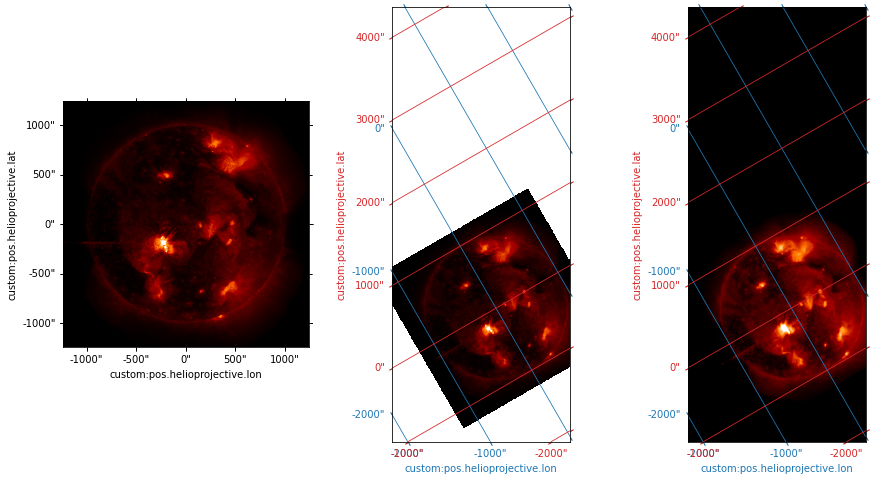

In [16]:
layer = 1
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(131,projection=moxsi_cube[select_slice][layer].wcs)
moxsi_cube[select_slice][layer].plot(axes=ax,**plot_props)
ax = fig.add_subplot(132, projection=sheared_cube[layer].wcs)
sheared_cube[layer].plot(axes=ax,**plot_props)
_ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})
ax = fig.add_subplot(133, projection=sheared_cube_sum[select_slice][layer].wcs)
sheared_cube_sum[select_slice][layer].plot(axes=ax,**plot_props)
_ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})

Can we go the other way?

In [17]:
cube_wcs = copy.deepcopy(moxsi_cube.wcs)
cube_wcs.wcs.crpix[2] = cube_wcs.wcs.crpix[2] - select_slice[0].start
unsheared_data = reproject.reproject_interp(
    sheared_cube_sum[select_slice],
    cube_wcs,
    shape_out=moxsi_cube[select_slice].data.shape,
    return_footprint=False,
)
dummy = np.zeros(moxsi_cube.data.shape)
dummy[select_slice] = unsheared_data
unsheared_data = dummy
unsheared_cube = ndcube.NDCube(unsheared_data, wcs=moxsi_cube.wcs)

<WCSAxesSubplot:>

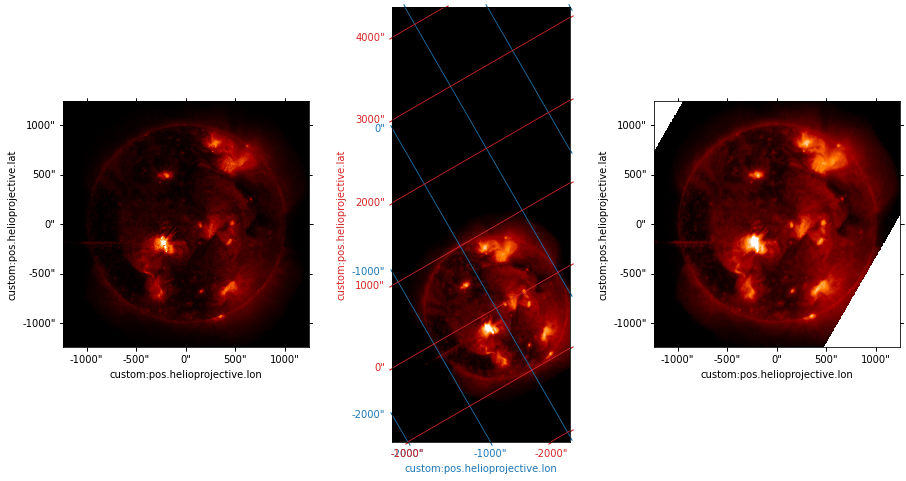

In [20]:
layer = 1
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(131,projection=moxsi_cube[select_slice][layer].wcs)
moxsi_cube[select_slice][layer].plot(axes=ax,**plot_props)
ax = fig.add_subplot(132, projection=sheared_cube_sum[select_slice][layer].wcs)
sheared_cube_sum[select_slice][layer].plot(axes=ax,**plot_props)
_ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})
ax = fig.add_subplot(133,projection=unsheared_cube[select_slice][layer].wcs)
unsheared_cube[select_slice][layer].plot(axes=ax,**plot_props)

Try it with a "more overlapped" example

In [17]:
iw_rank = moxsi_cube.data.mean(axis=(1,2)).argsort()[::-1]
new_data = np.zeros(moxsi_cube.data.shape)
for i in iw_rank[:20]:
    new_data[i,:,:] = moxsi_cube.data[i,:,:]
moxsi_cube_sparse = make_moxsi_ndcube(new_data, wavelength)
moxsi_overlap_fuller = construct_overlappogram(
    moxsi_cube_sparse, 
    roll_angle=20*u.deg,
    dispersion_angle=5*u.deg,
    observer=observer, 
    order=1,
)

In [18]:
cube_wcs = copy.deepcopy(moxsi_cube.wcs)
cube_wcs.wcs.crpix[2] = cube_wcs.wcs.crpix[2] - select_slice[0].start
unsheared_data_fuller = reproject.reproject_interp(
    moxsi_overlap_fuller[select_slice],
    cube_wcs,
    shape_out=moxsi_cube[select_slice].data.shape,
    return_footprint=False,
)
dummy = np.zeros(moxsi_cube.data.shape)
dummy[select_slice] = unsheared_data_fuller
unsheared_data_fuller = dummy
unsheared_cube_fuller = ndcube.NDCube(unsheared_data_fuller, wcs=moxsi_cube.wcs)

<WCSAxesSubplot:>

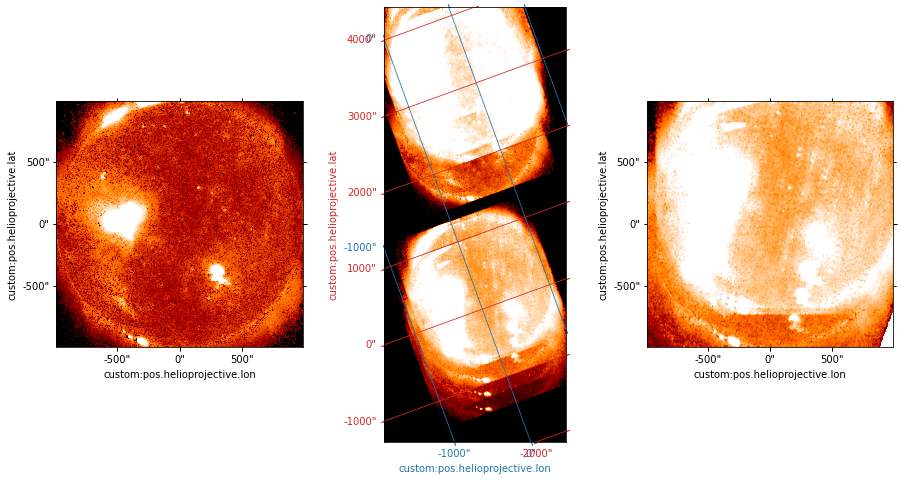

In [19]:
layer = 1
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(131,projection=moxsi_cube_sparse[select_slice][layer].wcs)
moxsi_cube_sparse[select_slice][layer].plot(axes=ax,**plot_props)
ax = fig.add_subplot(132, projection=moxsi_overlap_fuller[select_slice][layer].wcs)
moxsi_overlap_fuller[select_slice][layer].plot(axes=ax,**plot_props)
_ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})
ax = fig.add_subplot(133,projection=unsheared_cube_fuller[select_slice][layer].wcs)
unsheared_cube_fuller[select_slice][layer].plot(axes=ax,**plot_props)

In [24]:
scale = [u.Quantity(cd, cu)/u.pix for cd,cu in zip(moxsi_cube.wcs.wcs.cdelt,
                                             moxsi_cube.wcs.wcs.cunit)]
reference_pixel = [
    (DETECTOR_SHAPE[1] + 1)/2,
    (DETECTOR_SHAPE[0] + 1)/2 + 325,
    1,
] * u.pix
overlap_1 = reproject_to_overlappogram(moxsi_cube[325:335,...],
                                       DETECTOR_SHAPE,
                                       scale=scale,
                                       observer=observer,
                                       sum_over_lambda=True,
                                       reference_pixel=reference_pixel,
                                       #reproject_kwargs={'parallel':True}
                                       )

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7fd49eb6e820>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7fd486f28b80>)

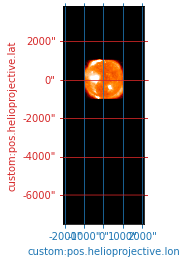

In [31]:
ax = overlap_1[0].plot(**plot_props)
color_lat_lon_axes(ax)